# Gradient Descent

In [570]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## Generate $n$D Data

In [571]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), np.identity(n)))
    
    return series

[[0.69646919 0.        ]
 [0.22685145 0.55131477]]


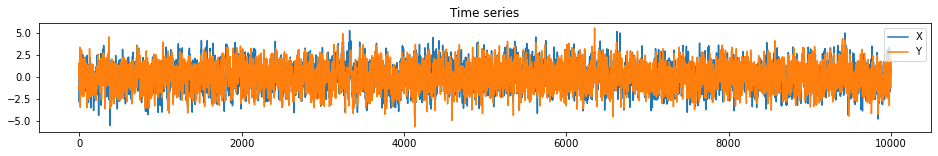

In [588]:
np.random.seed(seed = 123)

length, n = 10000, 2

# A matrix, lower triangular
A = np.tril(np.random.rand(n, n))

print(A)
# Permutation matrix
# P = np.array([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]])
P = np.array([[1.0, 0.0], [0.0, 1.0]])
# P = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])

# Generate nD data
series = generate_data_nD(length, n, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

## Expected cost when $P = I$
$$\mathbb{E}\left[\sum_{t = 2}^T\frac{1}{T - 1}\left\lVert \mathbf{X}_t - A\mathbf{X}_{t-1}\right\rVert_ 2^2\right]$$
$$= \sum_{t = 2}^T\frac{1}{T - 1}\mathbb{E}\left[\sum_{i = 1}^n\left(X_{i, t} - \left(A\mathbf{X}_{t-1}\right)_i\right)^2\right]$$
$$= \sum_{t = 2}^T\frac{1}{T - 1}\sum_{i = 1}^n\mathbb{E}\left[\left(\left(A \mathbf{X_{t - 1}}\right)_{i} + \sigma_i^2- \left(A\mathbf{X}_{t-1}\right)_i\right)^2\right]$$
$$= n\sum_{i = 1}^n \sigma_i^2,$$
where $\sigma_i$ is the variance of the $i$th variable, assuming the covariance is a diagonal matrix.

In [348]:
cost = 0
    
for t in range(1, length):
    val = np.matmul(P, series[t])
    est = np.matmul(A, np.matmul(P, series[t - 1]))
    cost += np.linalg.norm(val - est) ** 2
    
print(cost / (length - 1))

cost = 0
    
for t in range(1, length):
    val = series[t]
    est = np.matmul(A, series[t - 1])
    cost += np.linalg.norm(val - est) ** 2
    
print(cost / (length - 1))

print(n * 1)

1.9229855718485578
1.964426273198838
2


# $n$ Dimensions, $n^2 + (n - 1)^2$ variables.
## Cost function $C(P, A)$
The cost function resembles a least squares function:
\begin{align*}
    C = \frac{1}{T - 1}\sum_{t = 2}^T(y_t - y_{t, pred})^2
\end{align*}

However, our $y_t$ is $n$-dimensional, so we take the $2$-norm. Furthermore, $y_t = P \mathbf{X}_t$, and $y_{pred, t} = A P \mathbf{X}_{t - 1}$. Plugging this all in yields

\begin{align}
    C(P, A) &= \frac{1}{T - 1}\sum_{t=2}^T \left\lVert P\mathbf{X}_t - AP\mathbf{X}_{t-1})\right\rVert_2^2 \\
      &= \frac{1}{T - 1}\sum_{t=2}^T \sum_{i = 1}^n \left(\left(P\mathbf{X}_t\right)_i - \left(AP\mathbf{X}_{t-1}\right)_i\right)^2.
\end{align}

In [281]:
def C_n(variables, l = 0.01):
    P, A  = variables
    
    cost = 0
    
    for t in range(1, length):
        val = np.matmul(P, series[t])
        est = np.matmul(A, np.matmul(P, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost / (length - 1)

C_n([P, A])

3.9910228631325375

### Partial derivative of $C(P, A)$ for arbitrary $a_{ij}$ and arbitrary dimension
Now, taking the derivative of $C(P, A)$ with respect to $a_{ij}$ and using the chain rule, we get

$$\frac{\partial C(P, A)}{\partial a_{ij}} = -2 \sum_{t=2}^T \left(P \mathbf{X}_t - AP\mathbf{X}_{t-1} \right)_{(i)} \cdot \left(P\mathbf{X}_{t-1}\right)_{(j)},$$

for $i, j = 1, ..., n.$

In [282]:
def C_aij_n(variables, i = 1, j = 1, l = 0.01):
    """Calculate the derivative of C w.r.t aij"""
    
    P, A  = variables
    
    derivative = 0
    
    for t in range(1, length):
        val = np.matmul(P, series[t])[i - 1]
        est = np.matmul(A, np.matmul(P, series[t - 1]))[i - 1]
        
        derivative += 2 * (est - val) * np.matmul(P, series[t - 1])[j - 1]
        
    return derivative / (length - 1)

C_aij_n([P, A])

-0.012346018108301661

### Partial derivative of $C(P, A)$ for arbitrary $a_{ij}$ and arbitrary dimension
Now, taking the derivative of $C(P, A)$ with respect to $a_{ij}$ and using the chain rule, we get

$$\frac{\partial C(P, A)}{\partial a_{ij}} = -2 \sum_{t=2}^T \left(P \mathbf{X}_t - AP\mathbf{X}_{t-1} \right)_{(i)} \cdot \left(P\mathbf{X}_{t-1}\right)_{(j)},$$

for $i, j = 1, ..., n.$

In [283]:
def C_pij_n(variables, i = 1, j = 1, l = 0.01):
    """Calculate the derivative of C w.r.t p"""
    
    P, A = variables
    
    derivative = 0
    
    last = n - 1
    
    for t in range(1, length):
        
        for k in range(n):
            val = np.matmul(P, series[t])[k]
            est = np.matmul(A, np.matmul(P, series[t - 1]))[k]
        
            # derivative:
            derivative_k = 0
            
            # always contributing
            derivative_k -= A[k][i - 1] * (series[t - 1][j - 1] - series[t - 1][last]) 
            derivative_k -= A[k][last]  * (series[t - 1][last]  - series[t - 1][j - 1])
            
            # last one
            if k == last:
                derivative_k += series[t][last]  - series[t][j - 1]
            if k == i - 1:
                derivative_k += series[t][j - 1] - series[t][last]
                
            derivative += 2 * (val - est) * derivative_k
        
    return derivative / (length - 1)

C_pij_n([P, A])

-4.015196711145046

In [90]:
def verify_gradient_p(i, j):
    print(f"{i} {j}, ..., ", end = " ")
    x_lim_1, x_lim_2 = -0.1, 1.1
    p_list = np.linspace(x_lim_1, x_lim_2, 30)
    results = [[], []]

    for p in p_list:
        old_p = P[i - 1][j - 1]
        
        P[i - 1][n - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - p)
        P[i - 1][j - 1] = p
        
        results[0].append(C_n([P, A]))
        results[1].append(C_pij_n([P, A], i = i, j = j))

        P[i - 1][n - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - old_p)
        P[i - 1][j - 1] = old_p
        
    plt.xlabel(f"$p_{{{str(i) + str(j)}}}$")
    if i == 1 and j == 1:
        plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
        plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--')
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

1 1, ...,  1 2, ...,  2 1, ...,  2 2, ...,  

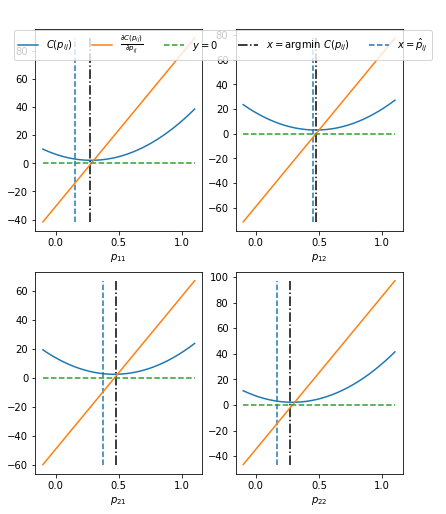

In [91]:
# Create a Position index
plt.figure(figsize = (3 * (n - 1), 3 * (n - 1)))
plt.subplots_adjust(bottom = -0.15, left = 0.05)
# total number of subplots
subplots = range(1, (n - 1) ** 2 + 1)

# create figure
fig = plt.figure(1)

# plot gradient for each p_ij
for k in range((n - 1) ** 2):
    ax = fig.add_subplot(n - 1, n - 1, subplots[k])
    verify_gradient_p(k // (n - 1) + 1, k % (n - 1) + 1)

fig.legend(loc = 'upper center', ncol = 5, borderaxespad = 3.0)
plt.show()

In [92]:
def verify_gradient_a(i, j):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-1.0, 1.0, 30)
    results = [[], []]

    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a

        results[0].append(C_n([P, A]))
        results[1].append(C_aij_n([P, A], i = i, j = j))

    A[i - 1][j - 1] = a_temp
        
    plt.xlabel(f"$a_{i}._{j}$")
    
    if i == 1 and j == 1:
        plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
        plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
        plt.plot([-1, 1], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")
    else:
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([-1, 1], [0, 0], linestyle = '--')
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

1 1, ...,  2 1, ...,  2 2, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

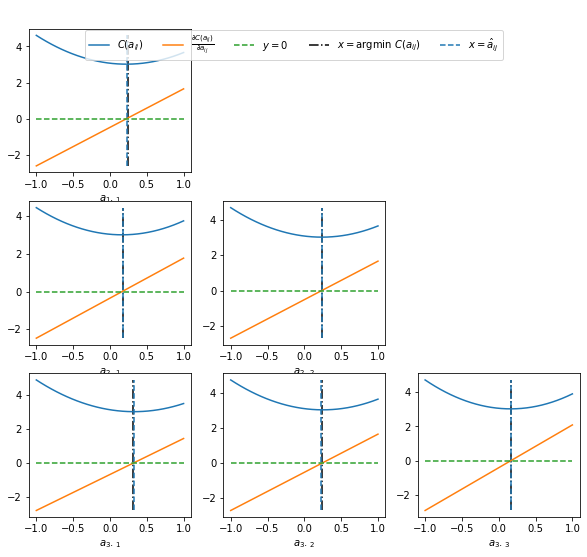

In [93]:
# Create a Position index
plt.figure(figsize = (3 * n, 3 * (n - 1)))
plt.subplots_adjust(bottom = -0.25, left = 0.05)

position = range(1, n ** 2 + 1)

fig = plt.figure(1)

for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    if k // n >= k % n:
        ax = fig.add_subplot(n, n, position[k])
        verify_gradient_a(k // n + 1, k % n + 1)

fig.legend(loc = 'upper center', ncol = 5, borderaxespad = 3.0)
plt.show()

In [21]:
print(A)

[[0.02785877 0.         0.         0.         0.        ]
 [0.01692426 0.03923057 0.         0.         0.        ]
 [0.01372712 0.02916199 0.01754289 0.         0.        ]
 [0.02951982 0.00729967 0.00701807 0.02126205 0.        ]
 [0.02537604 0.03397727 0.02897821 0.02444094 0.02889774]]


### Procedure
    While Cost Function changes:
        For $i, j = 1, ..., n - 1$:
            Approximate $p_{ij}$ using gradient descent
   
        For $i, j = 1, ..., n$:
            Approximate $a_{ij}$ using gradient descent

In [930]:
print(P, A)

[[0.20625559 0.20110624 0.21518947 0.18779849 0.18965021]
 [0.19344636 0.19849415 0.1841435  0.21318788 0.21072811]
 [0.20006843 0.20005873 0.19972831 0.20003514 0.2001094 ]
 [0.20064601 0.20012974 0.2013131  0.1988492  0.19906195]
 [0.19989254 0.19998141 0.19950308 0.20030343 0.20031954]] [[-0.02901068  0.          0.          0.          0.        ]
 [ 0.46002974 -0.49619255  0.          0.          0.        ]
 [ 0.45573605 -0.42743241 -0.06451568  0.          0.        ]
 [ 0.39434555 -0.43204736  0.00599866 -0.00248073  0.        ]
 [ 0.38097975 -0.44215453  0.00432472  0.10519756 -0.08277841]]


In [494]:
def gradient_descent(k):
    """
    Run Gradient Descent with Learning Parameter L on the kth variable until convergence.
    k is a number between 1 and ...
    """
    
    global L
    
    # If k is between 1 and n^2, estimate a_{k//n + 1, k%n + 1}
    if 1 <= k <= n ** 2:
        i = (k - 1) // n + 1
        j = (k - 1) % n + 1
        
        # lower triangular constraint: , j !> i
        if i >= j:
            # optimize A[(k-1)//n][(k-1)%n]
            # print(f"Optimizing A[{(k-1)//n}][{(k-1)%n}].")
            a_der, a_old = C_aij_n([P, A], i, j), 1e10
            while abs(a_der) > 1e-9 and abs(a_der) < abs(a_old):
                a_old = a_der
                A[i - 1][j - 1] -= L * a_der
                a_der = C_aij_n([P, A], i, j)
                # print(a_der)
        
    elif n ** 2 < k <= n ** 2 + (n - 1) ** 2:
        i = (k - n ** 2 - 1) // (n - 1) + 1
        j = (k - n ** 2 - 1) % (n - 1) + 1
        
        # print(f"Optimizing P[{i}][{j}].")
        p_der, p_old = C_pij_n([P, A], i, j), 1e10
        while abs(p_der) > 1e-9 and abs(p_der) < abs(p_old):
            p_old = p_der
            p_dif = L * p_der
            P[i - 1][j - 1] -= p_dif
            P[i - 1][n - 1] += p_dif
            P[n - 1][j - 1] += p_dif
            P[n - 1][n - 1] -= p_dif
            
            p_der = C_pij_n([P, A], i, j)
            if abs(p_old) < abs(p_der):
                print("A")
                L /= 10
                print(L)
                break
            
        # update other values for p
cost, old_cost = C_n([P, A]), 1e10
while old_cost - cost > 1e-6:
    old_cost = cost
    for k in range(1, n ** 2 + (n - 1) ** 2 + 1):
        gradient_descent(k)
        print(round(C_n([P, A]), 6), end = ", ")
    cost = C_n([P, A])
    print("Cost difference:", str(old_cost - cost))

print(C_n([P, A]))
print(P, A)

NameError: name 'L' is not defined

In [911]:
x1, x2 = 0.2, 0.5
a_tmp = A[0][0]
A[0][0] = x1
y1 = C_aij_n([P, A], 1, 1) 
A[0][0] = x2
y2 = C_aij_n([P, A], 1, 1) 
A[0][0] = a_tmp

a = (y1 - y2) / (x1 - x2)
b = y1 - a * x1
x_opt = -b / a

print(x_opt)
A[0][0] = x_opt
y_opt = C_aij_n([P, A], 1, 1) 
A[0][0] = a_tmp
print(y1, y2, y_opt)

-0.02870846773726601
0.09051323428652015 0.20924067168577629 3.222869641054008e-18


In [582]:
# Randomly initialize A_hat and P_hat
P_hat = gen_P(n)
A_hat = np.tril(np.random.rand(n, n))

In [586]:
def gradient_descent_fast(k):
    """
    Run Gradient Descent with Learning Parameter L on the kth variable until convergence.
    k is a number between 1 and ...
    """
    
    x1, x2 = 0.2, 0.5 # any arbitrary values, preferably between 0 and 1
    
    # If k is between 1 and n^2, estimate a_{k//n + 1, k%n + 1}
    if 1 <= k <= n ** 2:
        # get indices i, j = 1, ..., n
        i = (k - 1) // n + 1
        j = (k - 1) % n + 1
        
        # lower triangular constraint: , j !> i
        if i >= j:
            # compute y1
            A_hat[i - 1][j - 1] = x1
            y1 = C_aij_n([P, A_hat], i, j) 
            
            # compute y2
            A_hat[i - 1][j - 1] = x2
            y2 = C_aij_n([P, A_hat], i, j) 
            
            # compute A_ij_opt
            a = (y1 - y2) / (x1 - x2)
            b = y1 - a * x1
            A_hat[i - 1][j - 1] = -b / a
        
    elif n ** 2 < k <= n ** 2 + (n - 1) ** 2:
        # get indices i, j, in 1, ..., n - 1
        i = (k - n ** 2 - 1) // (n - 1) + 1
        j = (k - n ** 2 - 1) % (n - 1) + 1
        
        # print(f"Optimizing P[{i}][{j}].")
        
        # compute y1
        p_dif = P_hat[i - 1][j - 1] - x1
        P_hat[i - 1][j - 1] -= p_dif 
        P_hat[i - 1][n - 1] += p_dif
        P_hat[n - 1][j - 1] += p_dif
        P_hat[n - 1][n - 1] -= p_dif
        
        y1 = C_pij_n([P_hat, A], i, j) 
        
        # compute y2
        p_dif = P_hat[i - 1][j - 1] - x2
        P_hat[i - 1][j - 1] -= p_dif 
        P_hat[i - 1][n - 1] += p_dif
        P_hat[n - 1][j - 1] += p_dif
        P_hat[n - 1][n - 1] -= p_dif
        
        y2 = C_pij_n([P_hat, A], i, j) 
        
        # compute p_ij_opt
        a = (y1 - y2) / (x1 - x2)
        b = y1 - a * x1
        p_ij_opt = -b / a
        
        # update P
        p_dif = P_hat[i - 1][j - 1] - p_ij_opt
        P_hat[i - 1][j - 1] -= p_dif 
        P_hat[i - 1][n - 1] += p_dif
        P_hat[n - 1][j - 1] += p_dif
        P_hat[n - 1][n - 1] -= p_dif

# initialize cost, old_cost
cost, old_cost = C_n([P_hat, A_hat]), 1e10

# gradient descent until cost does not decrease by more than 1e-6
while abs(old_cost - cost) > 1e-4:
    
    # check old cost
    old_cost = cost
    
    # for all parameters
    for k in range(1, n ** 2 + (n - 1) ** 2 + 1):
        # optimize parameter k using gradient descent fast
        gradient_descent_fast(k)
    
    # check new cost
    cost = C_n([P_hat, A_hat])
    
    # print cost difference
    print(round(cost, 5), end = " ")
    print("Cost diff.:", str(round(old_cost - cost, 8)), end = ", ")

# "convergence!" print results
print("\nOptimal cost:", C_n([P_hat, A_hat]))
print("\nP:\n", P_hat)
print("A:\n", A_hat)

1.03502 Cost diff.: -0.00069783, 1.03474 Cost diff.: 0.00027446, 1.03474 Cost diff.: 2.2e-07, 
Optimal cost: 1.034740356701763

P:
 [[0.50381922 0.49618078]
 [0.49578585 0.50421415]]
A:
 [[0.35199186 0.        ]
 [0.09929697 0.27046206]]


In [585]:
print("Actual P:\n", P)
print("Actual A:\n", A)

Actual P:
 [[1. 0.]
 [0. 1.]]
Actual A:
 [[0.34823459 0.        ]
 [0.11342573 0.27565738]]


### Derive permutation matrix $P^*$ from doubly stochastic matrix $\hat{P}$
#### Approach 1, index with largest entry gets 1, set other values in the corresponding row and column to zero.

In [563]:
# reset and normalize P
P_2 = P_hat.copy()
P_2 /= np.min(P_2)

In [564]:
# for each row
for _ in range(n):
    # get largest entry in P
    i, j = np.unravel_index(np.argmax(P_2, axis=None), P_hat.shape)
    
    # set all other values in that row and column to zero
    for i1 in range(n):
        P_2[i][i1] = 0
        P_2[i1][j] = 0
        
    # set the largest entry in P to 1
    P_2[i][j] = 1

    print(P_2, end = "\n\n")

[[1.13953776 0.         1.07947225]
 [1.09160781 0.         1.07308739]
 [0.         1.         0.        ]]

[[1.         0.         0.        ]
 [0.         0.         1.07308739]
 [0.         1.         0.        ]]

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]



#### Approach 2, index with relatively largest entry in row gets 1, set other values in the corresponding row and column to zero.

In [565]:
# reset P
P_2 = P_hat.copy()

In [566]:
# for each row
for _ in range(n):
    # Normalize each row by dividing by its smallest non-zero entry
    for i in range(n):
        P_2[i] /= np.min(P_2[i][np.nonzero(P_2[i])])

    # get largest entry in P
    i, j = np.unravel_index(np.argmax(P_2, axis=None), P_hat.shape)

    # set all other values in that row and column to zero
    for i1 in range(n):
        P_2[i][i1] = 0
        P_2[i1][j] = 0

    # set the largest entry in P to 1
    P_2[i][j] = 1

    print(P_2, end = "\n\n")

[[1.12603468 0.         1.06668092]
 [1.02372796 0.         1.00635921]
 [0.         1.         0.        ]]

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]



#### Approach 3, index with relatively largest entry in column gets 1, set other values in the corresponding row and column to zero.

In [567]:
# reset P
P_2 = P_hat.copy()

In [568]:
# for each row
for _ in range(n):
    # Normalize each row by dividing by its smallest non-zero entry
    for j in range(n):
        P_2[:, j] /= np.min(P_2[:, j][np.nonzero(P_2[:, j])])

    # get largest entry in P
    i, j = np.unravel_index(np.argmax(P_2, axis=None), P_hat.shape)

    # set all other values in that row and column to zero
    for i1 in range(n):
        P_2[i][i1] = 0
        P_2[i1][j] = 0

    # set the largest entry in P to 1
    P_2[i][j] = 1

    print(P_2, end = "\n\n")

[[1.         0.         0.        ]
 [0.         1.0536712  1.        ]
 [0.         1.13894761 1.00494722]]

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]



#### Approach 4, Hungarian Algorithm

In [569]:
from scipy import optimize

# get row and index of the corresponding ones of the Hungarian algorithm
row_ind, col_ind = optimize.linear_sum_assignment(P_hat)

# initialize P_matrix
P_matrix = np.array(np.zeros((n, n)))

# assign ones to the corresponding entries
for i in range(n):
    P_matrix[row_ind[i]][col_ind[i]] = 1

print(np.rot90(P_matrix))

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


### Conclusion
Using gradient descent to iteratively and alternatingly update the $n^2$ (or $\frac{n(n+1)}{2}$ if $A$ is LT) parameters in $A$ and the $(n - 1)^2$ parameters in $P$, we arrive slowly but surely at the global optimum. We can speed this up by exploiting the fact that all partial derivatives are linear, hence we can find the optimum for each parameter quickly at each iteration.

If we pick $P = I$, then this method can quickly retrieve the unerlying values of $A$, regardless whether $A$ is full or LT.

If we generate $A$ uniformly at random, and take the lower triangle, and do not use any $P$, we see that all entries $p_{ij}$ in $P$ tend to be close to $\frac{1}{n}$.

If we generate the data with any doubly stochastic $P$, then we see that the values of $\hat{P}$ tend to $\frac{1}{n}$, and do not reveal the underlying values of the actual $P$.

If we generate data with a permutation matrix $P = \begin{pmatrix} 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$, the matrix $\hat{P}$ again tends to a uniformly doubly stochastic matrix.

### Misc
#### Generate a random doubly stochastic matrix

In [147]:
def gen_P(n):
    P = np.random.random((n, n))
    
    rsum = 0
    csum = 0

    while (np.any(np.round(rsum, 3) != 1)) | (np.any(np.round(csum, 3) != 1)):
        P /= P.sum(0)
        P = P / P.sum(1)[:, np.newaxis]
        rsum = P.sum(1)
        csum = P.sum(0)
        
    return P

P = gen_P(n)
print(P)

[[0.15773687 0.2643179  0.4456305  0.13231472]
 [0.10983517 0.24327769 0.35285257 0.29403458]
 [0.29430265 0.18767391 0.18403963 0.33398381]
 [0.43838834 0.30475254 0.01713113 0.23972799]]
